# Satellite image classification

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from sklearn.model_selection import train_test_split
import seaborn as sb

In [2]:
# Reading datasets
X_train = pd.read_csv('./data/X_train_sat4.csv',header=None)
y_train = pd.read_csv('./data/y_train_sat4.csv',header=None)
X_test = pd.read_csv('./data/X_test_sat4.csv', header=None, engine='python') #This one give me an error because of the format of the data, so I used the engine='python' argument 
y_test = pd.read_csv('./data/y_test_sat4.csv', header=None)

In [3]:
# View the first 5 rows
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,3126,3127,3128,3129,3130,3131,3132,3133,3134,3135
0,104,103,94,133,114,115,106,145,104,110,...,95,141,101,103,92,138,103,110,99,148
1,175,149,130,146,169,148,130,141,166,139,...,119,132,137,133,121,134,134,128,119,132
2,113,114,105,163,126,131,125,176,119,125,...,129,177,122,126,113,172,130,136,131,181
3,107,104,100,124,108,105,102,126,105,104,...,74,85,74,70,63,78,83,79,73,92
4,105,100,95,132,77,72,62,114,76,77,...,86,129,106,100,85,128,118,109,99,130


When you used pd.read_csv function, you get a dataframe. What we need is a numpy array, so we can easy convert it by using np.array function. 

In [4]:
# Converting to numpy array and normalizing images.
X_train = np.array(X_train)/255
y_train = np.array(y_train)
X_test = np.array(X_test)/255
y_test = np.array(y_test)

In [5]:
# Viewing the shape of the training images
X_train.shape

(400000, 3136)

We got 400,000 images in the training set, but they have not the right shape, so we have to reshape the image data before continue.

In [6]:
# Reshaping the images
X_train = X_train.reshape(X_train.shape[0],28,28,4).astype(float)
X_test = X_test.reshape(X_test.shape[0],28,28,4).astype(float)

In [7]:
X_train.shape

(400000, 28, 28, 4)

The images has the right  shape, we can save those image to avoid processing the data in the future.

In [8]:
np.save('dataset/X_train.npy',X_train)
np.save('dataset/X_test.npy',X_test)
np.save('dataset/y_train.npy',y_train)
np.save('dataset/y_test.npy',y_test)

In [2]:
X_train = np.load('dataset/X_train.npy')
y_train = np.load('dataset/y_train.npy')
X_test = np.load('dataset/X_test.npy')
y_test = np.load('dataset/y_test.npy')

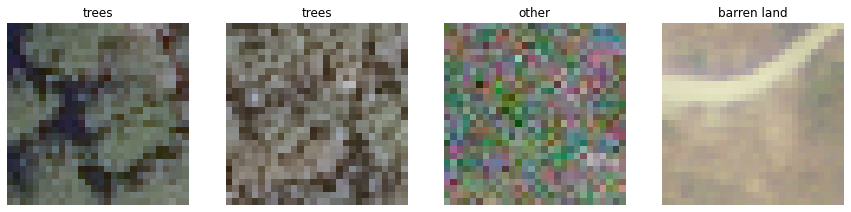

In [11]:
# Ploting some images.
fig = plt.figure(figsize=(15, 13))
columns = 4
rows = 1
ax = []
y_names = ['barren land', 'trees', 'grassland', 'other']
y_train_names = [y_names[i] for i in np.argmax(y_train,axis=1)]
for i in range(columns*rows):
    n = np.random.randint(X_train.shape[0])
    ax.append(fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title(y_train_names[n])
    plt.axis('off')
    plt.imshow(X_train[n,:,:,0:3])

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [5]:
def create_network(input_shape):
    input = Input(shape=input_shape)
    x = Flatten(input_shape=input_shape)(input)
    x = Dense(50, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros())(x)
    x = Dropout(0.2)(x)
    x = Dense(4, activation='softmax', kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros())(x)
    return Model(input, x)

input_shape = X_train.shape[1:]
model = create_network(input_shape)

SGD = optimizers.SGD(lr=0.01) 
model.compile(loss='categorical_crossentropy' ,optimizer=SGD, metrics='accuracy')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs',
                                                      profile_batch=5)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 4)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                156850    
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 204       
Total params: 157,054
Trainable params: 157,054
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = model.fit(X_train, y_train, batch_size=30 ,epochs=200,
                  validation_data=(X_valid, y_valid),callbacks=[tensorboard_callback])

Epoch 1/200
   1/8934 [..............................] - ETA: 8s - loss: 1.3844 - accuracy: 0.2000WARNING:tensorflow:From C:\Users\phyos\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
8934/8934 [==============================] - 19s 2ms/step - loss: 0.6979 - accuracy: 0.7118 - val_loss: 0.5315 - val_accuracy: 0.7870
Epoch 2/200
8934/8934 [==============================] - 18s 2ms/step - loss: 0.5339 - accuracy: 0.7853 - val_loss: 0.4439 - val_accuracy: 0.8275
Epoch 3/200
8934/8934 [==============================] - 18s 2ms/step - loss: 0.4814 - accuracy: 0.8092 - val_loss: 0.4875 - val_accuracy: 0.8012
Epoch 4/200
8934/8934 [==============================] - 18s 2ms/step - loss: 0.4497 - accuracy: 0.8237 - val_loss: 0.4122 - val_accuracy: 0.8401
Epoch 5/200
8934/8934 [=========

8934/8934 [==============================] - 18s 2ms/step - loss: 0.2682 - accuracy: 0.9080 - val_loss: 0.2397 - val_accuracy: 0.9196
Epoch 53/200
8934/8934 [==============================] - 18s 2ms/step - loss: 0.2664 - accuracy: 0.9088 - val_loss: 0.2359 - val_accuracy: 0.9177
Epoch 54/200
8934/8934 [==============================] - 18s 2ms/step - loss: 0.2655 - accuracy: 0.9090 - val_loss: 0.2603 - val_accuracy: 0.9130
Epoch 55/200
8934/8934 [==============================] - 18s 2ms/step - loss: 0.2646 - accuracy: 0.9092 - val_loss: 0.2416 - val_accuracy: 0.9183
Epoch 56/200
8934/8934 [==============================] - 18s 2ms/step - loss: 0.2629 - accuracy: 0.9109 - val_loss: 0.2181 - val_accuracy: 0.9293
Epoch 57/200
8934/8934 [==============================] - 18s 2ms/step - loss: 0.2628 - accuracy: 0.9105 - val_loss: 0.2328 - val_accuracy: 0.9173
Epoch 58/200
8934/8934 [==============================] - 18s 2ms/step - loss: 0.2622 - accuracy: 0.9103 - val_loss: 0.2229 - val_a

Epoch 108/200
8934/8934 [==============================] - 18s 2ms/step - loss: 0.2220 - accuracy: 0.9263 - val_loss: 0.1797 - val_accuracy: 0.9428
Epoch 109/200
8934/8934 [==============================] - 18s 2ms/step - loss: 0.2175 - accuracy: 0.9281 - val_loss: 0.1919 - val_accuracy: 0.9385
Epoch 110/200
8934/8934 [==============================] - 18s 2ms/step - loss: 0.2185 - accuracy: 0.9277 - val_loss: 0.1910 - val_accuracy: 0.9375
Epoch 111/200
8934/8934 [==============================] - 18s 2ms/step - loss: 0.2192 - accuracy: 0.9276 - val_loss: 0.1865 - val_accuracy: 0.9429
Epoch 112/200
8934/8934 [==============================] - 18s 2ms/step - loss: 0.2168 - accuracy: 0.9284 - val_loss: 0.1877 - val_accuracy: 0.9389
Epoch 113/200
8934/8934 [==============================] - 18s 2ms/step - loss: 0.2167 - accuracy: 0.9284 - val_loss: 0.1999 - val_accuracy: 0.9380
Epoch 114/200
8934/8934 [==============================] - 18s 2ms/step - loss: 0.2163 - accuracy: 0.9287 - val_

8934/8934 [==============================] - 18s 2ms/step - loss: 0.1925 - accuracy: 0.9369 - val_loss: 0.2295 - val_accuracy: 0.9223
Epoch 164/200
8934/8934 [==============================] - 18s 2ms/step - loss: 0.1932 - accuracy: 0.9367 - val_loss: 0.1704 - val_accuracy: 0.9468
Epoch 165/200
8934/8934 [==============================] - 18s 2ms/step - loss: 0.1928 - accuracy: 0.9371 - val_loss: 0.1733 - val_accuracy: 0.9486
Epoch 166/200
8934/8934 [==============================] - 18s 2ms/step - loss: 0.1922 - accuracy: 0.9370 - val_loss: 0.1825 - val_accuracy: 0.9419
Epoch 167/200
8934/8934 [==============================] - 20s 2ms/step - loss: 0.1912 - accuracy: 0.9376 - val_loss: 0.2166 - val_accuracy: 0.9318
Epoch 168/200
8934/8934 [==============================] - 18s 2ms/step - loss: 0.1917 - accuracy: 0.9368 - val_loss: 0.1756 - val_accuracy: 0.9441
Epoch 169/200
8934/8934 [==============================] - 18s 2ms/step - loss: 0.1911 - accuracy: 0.9375 - val_loss: 0.1765 -

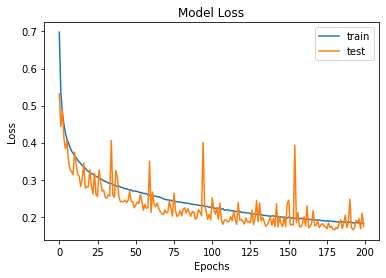

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

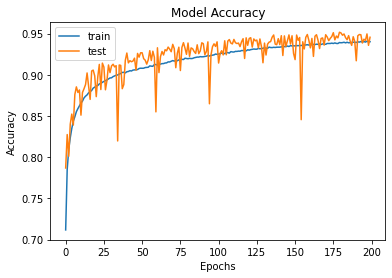

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [9]:
results = model.evaluate(X_test,y_test)
print("test loss, test acc:", results)

3125/3125 [==============================] - 5s 2ms/step - loss: 0.1731 - accuracy: 0.9471
test loss, test acc: [0.1730877161026001, 0.9471399784088135]


In [10]:
pred=model.predict(X_test) 
y_pred=np.argmax(pred,axis=1)
y_test_real=np.argmax(y_test,axis=1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_real, y_pred)
df_cm = pd.DataFrame(cm, 
  index = [ 'tierras estériles', 'árboles', 'pastizales', 'otras'],
  columns = ['tierras estériles', 'árboles', 'pastizales', 'otras'])
df_cm

,tierras estériles,árboles,pastizales,otras
tierras estériles,24970,2,699,518
árboles,0,18434,329,1468
pastizales,359,265,16354,968
otras,217,160,301,34956


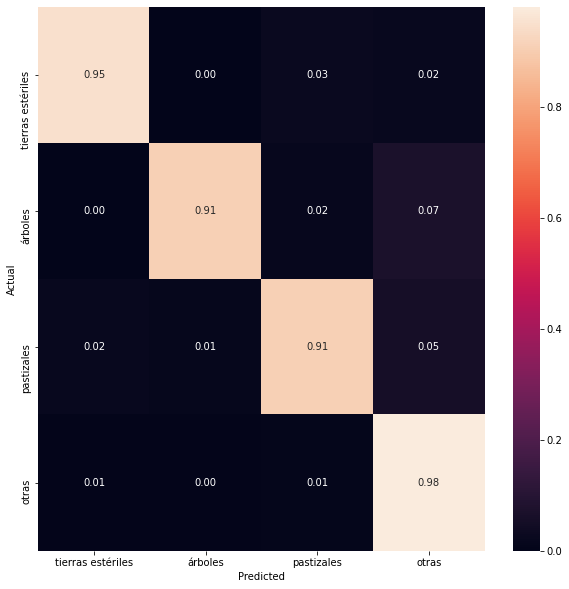

In [11]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sb.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['tierras estériles', 'árboles', 'pastizales', 'otras'], yticklabels=[ 'tierras estériles', 'árboles', 'pastizales', 'otras'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [12]:
def create_network(input_shape):
    input = Input(shape=input_shape)
    x = Flatten(input_shape=input_shape)(input)
    x = Dense(200, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros())(x)
    x = Dropout(0.2)(x)
    x = Dense(50, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros())(x)
    x = Dropout(0.2)(x)
    x = Dense(4, activation='softmax', kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros())(x)
    return Model(input, x)

input_shape = X_train.shape[1:]
model = create_network(input_shape)

SGD = optimizers.SGD(lr=0.01) 
model.compile(loss='categorical_crossentropy' ,optimizer=SGD, metrics='accuracy')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs',
                                                      profile_batch=5)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 4)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               627400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                

In [13]:
history = model.fit(X_train, y_train, batch_size=30 ,epochs=200,
                  validation_data=(X_valid, y_valid),callbacks=[tensorboard_callback])

Epoch 1/200
8934/8934 [==============================] - 21s 2ms/step - loss: 0.8040 - accuracy: 0.6599 - val_loss: 0.5159 - val_accuracy: 0.7941
Epoch 2/200
8934/8934 [==============================] - 19s 2ms/step - loss: 0.5238 - accuracy: 0.7882 - val_loss: 0.5437 - val_accuracy: 0.7372
Epoch 3/200
8934/8934 [==============================] - 20s 2ms/step - loss: 0.4408 - accuracy: 0.8293 - val_loss: 0.3943 - val_accuracy: 0.8541
Epoch 4/200
8934/8934 [==============================] - 19s 2ms/step - loss: 0.3861 - accuracy: 0.8537 - val_loss: 0.3935 - val_accuracy: 0.8533
Epoch 5/200
8934/8934 [==============================] - 20s 2ms/step - loss: 0.3538 - accuracy: 0.8678 - val_loss: 0.8184 - val_accuracy: 0.6145
Epoch 6/200
8934/8934 [==============================] - 20s 2ms/step - loss: 0.3302 - accuracy: 0.8781 - val_loss: 0.3606 - val_accuracy: 0.8519
Epoch 7/200
8934/8934 [==============================] - 19s 2ms/step - loss: 0.3132 - accuracy: 0.8853 - val_loss: 0.4694 -

Epoch 57/200
8934/8934 [==============================] - 19s 2ms/step - loss: 0.1380 - accuracy: 0.9531 - val_loss: 0.1265 - val_accuracy: 0.9581
Epoch 58/200
8934/8934 [==============================] - 20s 2ms/step - loss: 0.1369 - accuracy: 0.9529 - val_loss: 0.5953 - val_accuracy: 0.7864
Epoch 59/200
8934/8934 [==============================] - 20s 2ms/step - loss: 0.1359 - accuracy: 0.9534 - val_loss: 0.1836 - val_accuracy: 0.9322
Epoch 60/200
8934/8934 [==============================] - 20s 2ms/step - loss: 0.1352 - accuracy: 0.9534 - val_loss: 0.1108 - val_accuracy: 0.9633
Epoch 61/200
8934/8934 [==============================] - 21s 2ms/step - loss: 0.1329 - accuracy: 0.9549 - val_loss: 0.1136 - val_accuracy: 0.9616
Epoch 62/200
8934/8934 [==============================] - 19s 2ms/step - loss: 0.1318 - accuracy: 0.9550 - val_loss: 0.1084 - val_accuracy: 0.9643
Epoch 63/200
8934/8934 [==============================] - 20s 2ms/step - loss: 0.1308 - accuracy: 0.9550 - val_loss: 0

8934/8934 [==============================] - 19s 2ms/step - loss: 0.1027 - accuracy: 0.9656 - val_loss: 0.0934 - val_accuracy: 0.9693
Epoch 113/200
8934/8934 [==============================] - 20s 2ms/step - loss: 0.1010 - accuracy: 0.9658 - val_loss: 0.1011 - val_accuracy: 0.9679
Epoch 114/200
8934/8934 [==============================] - 19s 2ms/step - loss: 0.1001 - accuracy: 0.9664 - val_loss: 0.0951 - val_accuracy: 0.9691
Epoch 115/200
8934/8934 [==============================] - 20s 2ms/step - loss: 0.0999 - accuracy: 0.9658 - val_loss: 0.0888 - val_accuracy: 0.9716
Epoch 116/200
8934/8934 [==============================] - 20s 2ms/step - loss: 0.0995 - accuracy: 0.9660 - val_loss: 0.0904 - val_accuracy: 0.9705
Epoch 117/200
8934/8934 [==============================] - 20s 2ms/step - loss: 0.1007 - accuracy: 0.9658 - val_loss: 0.1414 - val_accuracy: 0.9488
Epoch 118/200
8934/8934 [==============================] - 20s 2ms/step - loss: 0.1007 - accuracy: 0.9661 - val_loss: 0.0895 -

8934/8934 [==============================] - 20s 2ms/step - loss: 0.0860 - accuracy: 0.9709 - val_loss: 0.0913 - val_accuracy: 0.9680
Epoch 168/200
8934/8934 [==============================] - 19s 2ms/step - loss: 0.0854 - accuracy: 0.9707 - val_loss: 0.0823 - val_accuracy: 0.9724
Epoch 169/200
8934/8934 [==============================] - 20s 2ms/step - loss: 0.0849 - accuracy: 0.9712 - val_loss: 0.0751 - val_accuracy: 0.9760
Epoch 170/200
8934/8934 [==============================] - 20s 2ms/step - loss: 0.0856 - accuracy: 0.9706 - val_loss: 0.0834 - val_accuracy: 0.9726
Epoch 171/200
8934/8934 [==============================] - 19s 2ms/step - loss: 0.0838 - accuracy: 0.9713 - val_loss: 0.0825 - val_accuracy: 0.9729
Epoch 172/200
8934/8934 [==============================] - 20s 2ms/step - loss: 0.0841 - accuracy: 0.9714 - val_loss: 0.0851 - val_accuracy: 0.9729
Epoch 173/200
8934/8934 [==============================] - 20s 2ms/step - loss: 0.0853 - accuracy: 0.9708 - val_loss: 0.0848 -

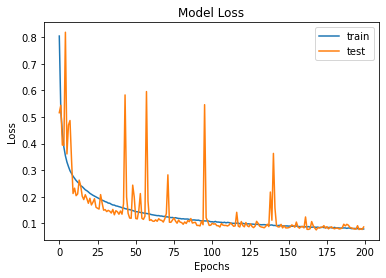

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

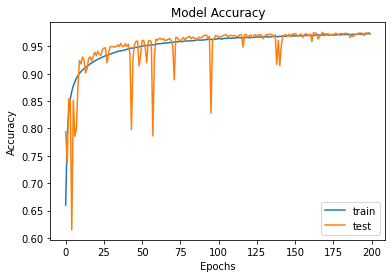

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [16]:
results = model.evaluate(X_test,y_test)
print("test loss, test acc:", results)

3125/3125 [==============================] - 4s 1ms/step - loss: 0.0830 - accuracy: 0.9740
test loss, test acc: [0.08303239196538925, 0.9739699959754944]


In [17]:
pred=model.predict(X_test)
y_pred=np.argmax(pred,axis=1)
y_test_real=np.argmax(y_test,axis=1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_real, y_pred)
df_cm = pd.DataFrame(cm, 
  index = [ 'tierras estériles', 'árboles', 'pastizales', 'otras'],
  columns = ['tierras estériles', 'árboles', 'pastizales', 'otras'])
df_cm

,tierras estériles,árboles,pastizales,otras
tierras estériles,25559,6,433,191
árboles,1,19828,88,314
pastizales,518,167,16808,453
otras,162,72,198,35202


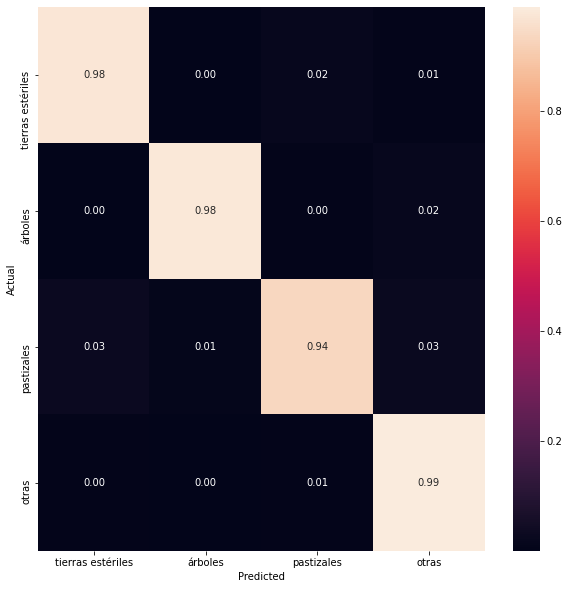

In [18]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sb.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['tierras estériles', 'árboles', 'pastizales', 'otras'], yticklabels=[ 'tierras estériles', 'árboles', 'pastizales', 'otras'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)